# Predicting Mortgage Delinquency Risk

**Note: this is a new exercise, so if you find something weird, please bring it to my attention.**

You have been hired by a mortgage servicing firm (a company that buys mortgages and then collects mortgage payments from homeowners) to build a model to answer the question: 

**Given all available information about a newly issued mortgage, what is the likelihood that the mortgage will enter delinquency (the homeowner will be at least 30 days late on a mortgage payment) during the first two years of the mortgage?**

The servicer's hope, obviously, is to differentiate between mortgages to try and purchase (those that will be consistently paid) and mortgages they wish to avoid.

For this task, you have been given [REAL data on a sample of all US Standard single family home mortgages purchased or insured by Freddie Mac](https://www.freddiemac.com/research/datasets/sf-loanlevel-dataset) in a single calendar year along with payment data from that and two subsequent years.


## Gradescope Autograding

Please follow [all standard guidance](https://www.practicaldatascience.org/html/autograder_guidelines.html) for submitting this assignment to the Gradescope autograder, including storing your solutions in a dictionary called `results` and ensuring your notebook runs from the start to completion without any errors.

For this assignment, please name your file `exercise_passive_prediction.ipynb` before uploading.

You can check that you have answers for all questions in your `results` dictionary with this code:

```python
assert set(results.keys()) == {
    "ex2_merge_type",
    "ex4_num_mortgages",
    "ex5_num_obs",
    "ex7_num_mortgages",
    "ex7_share_delinquent",
    "ex10_num_obs",
    "ex12_roc_auc",
    "ex14_false_negative_rate",
    "ex16_num_obs",
    "ex16_share_delinquent",
    "ex17_false_negative_rate",
}
```


### Submission Limits

Please remember that you are **only allowed FOUR submissions to the autograder.** Your last submission (if you submit 4 or fewer times), or your third submission (if you submit more than 4 times) will determine your grade Submissions that error out will **not** count against this total.

That's one more than usual in case there are issues with exercise clarity.

## Data Cleaning and Organization

Data for this exercise can be [found here](https://github.com/nickeubank/MIDS_Data/tree/master/mortgages/2004). This folder includes both the data to be used and documentation, though you can find [supplemental documentation here](https://www.freddiemac.com/research/datasets/sf-loanlevel-dataset).

The only difference between this data and the original Freddie Mac sampled data is that I've limited the scope of service data to three calendar years.

### Exercise 1

Begin by loading both: 

- the mortgage origination file (`sample_orig_2004.txt`). This *should* contain information on all mortgages issued in 2004, along with non-time varying features of these mortgages (the initial amount, the credit score of the applicant, etc.), and 
- the servicing data (`sample_svcg_2004orig_3years.txt`). This contains monthly records of all recorded payments (or non-payments) for all mortgages issued in 2004 during the calendar years of 2004, 2005, and 2006.

So the autograder can see the data, be sure to load it directly from a URL (don't download and load from your own system).

Load the data AND ensure your data has column names. You will likely need to reference the documentation to figure out how to do so.

In [1]:
# Lets add the headers to the data
import warnings

warnings.filterwarnings("ignore")

# Load the data from a URL
import pandas as pd
import numpy as np

pd.set_option("mode.copy_on_write", True)

# Set the URL for the data
url_orig = "https://github.com/nickeubank/MIDS_Data/raw/master/mortgages/2004/sample_orig_2004.txt"
url_svcg = "https://github.com/nickeubank/MIDS_Data/raw/master/mortgages/2004/sample_svcg_2004orig_3years.txt"

In [2]:
# Load the head labels for ORIG file
# headers_orig = pd.read_excel("file_layout.xlsx", skiprows=1)
# Select the second column
# second_column = headers_orig.iloc[:, 1]
# Convert the second column to a list
# head_labels_orig = second_column.tolist()
# print(head_labels_orig)

# Load the head labels for SVCG file
# head_svcg = pd.read_excel(
#    "file_layout.xlsx", skiprows=1, sheet_name="Monthly Performance Data File"
# )
# second_column_svcg = head_svcg.iloc[:, 1]
# head_labels_svcg = second_column_svcg.tolist()
# print(head_labels_svcg)

In [3]:
head_labels_orig = [
    "Credit Score",
    "First Payment Date",
    "First Time Homebuyer Flag",
    "Maturity Date",
    "Metropolitan Statistical Area (MSA) Or Metropolitan Division",
    "Mortgage Insurance Percentage (MI %)",
    "Number of Units",
    "Occupancy Status",
    "Original Combined Loan-to-Value (CLTV)",
    "Original Debt-to-Income (DTI) Ratio",
    "Original UPB",
    "Original Loan-to-Value (LTV)",
    "Original Interest Rate",
    "Channel",
    "Prepayment Penalty Mortgage (PPM) Flag",
    "Amortization Type (Formerly Product Type)",
    "Property State",
    "Property Type",
    "Postal Code",
    "Loan Sequence Number",
    "Loan Purpose",
    "Original Loan Term",
    "Number of Borrowers",
    "Seller Name",
    "Servicer Name",
    "Super Conforming Flag",
    "Pre-HARP Loan Sequence Number",
    "Program Indicator",
    "HARP Indicator",
    "Property Valuation Method",
    "Interest Only (I/O) Indicator",
    "Mortgage Insurance Cancellation Indicator",
]

head_labels_svcg = [
    "Loan Sequence Number",
    "Monthly Reporting Period",
    "Current Actual UPB",
    "Current Loan Delinquency Status",
    "Loan Age",
    "Remaining Months to Legal Maturity",
    "Defect Settlement Date",
    "Modification Flag",
    "Zero Balance Code",
    "Zero Balance Effective Date",
    "Current Interest Rate",
    "Current Deferred UPB",
    "Due Date of Last Paid Installment (DDLPI)",
    "MI Recoveries",
    "Net Sales Proceeds",
    "Non MI Recoveries",
    "Expenses",
    "Legal Costs",
    "Maintenance and Preservation Costs",
    "Taxes and Insurance",
    "Miscellaneous Expenses",
    "Actual Loss Calculation",
    "Modification Cost",
    "Step Modification Flag",
    "Deferred Payment Plan",
    "Estimated Loan-to-Value (ELTV)",
    "Zero Balance Removal UPB",
    "Delinquent Accrued Interest",
    "Delinquency Due to Disaster",
    "Borrower Assistance Status Code",
    "Current Month Modification Cost",
    "Interest Bearing UPB",
]

In [4]:
# Lets add the headers to the data
import warnings

warnings.filterwarnings("ignore")

data_orig = pd.read_csv(url_orig, sep="|", header=None, names=head_labels_orig)
data_svcg = pd.read_csv(url_svcg, sep="|", header=None, names=head_labels_svcg)

### Exercise 2

What is the unit of observation in `sample_orig_2004.txt` and in `sample_svcg_2004orig_3years.txt`?

The unit of observation in `sample_orig_2004.txt` is a single family loan and the unit of observation in `sample_svcg_2004orig_3years.txt` is the monthly performance of each loan in the origination data file.

### Exercise 3

Merge your two datasets. Be sure to use the `validate` keyword argument in `merge`.

Assuming that you list the data associated with `sample_orig_2004.txt` first and `sample_svcg_2004orig_3years.txt` second, what keyword are you passing to `validate`? Store your answer as a string (use one of: `"1:1"`, `"m:1"`, `"1:m"`, `"m:m"`) in a dictionary called `results` under the key `ex2_merge_type`.

In [5]:
# Lets merge our data by the Loan Sequence Number using validate to check if the data is consistent
results = {}
validate_as = "1:m"

results["ex2_merge_type"] = validate_as

data_merged = pd.merge(
    data_orig, data_svcg, on="Loan Sequence Number", how="inner", validate="one_to_many"
)

print(f"We are passing validate as {validate_as} to check if the data is consistent")

We are passing validate as 1:m to check if the data is consistent


### Exercise 4

Mortgages come in many shapes and flavors, however your servicer is only interested in predicting default for the more standard form of mortgage. Subset your data to only include:

- Mortgages taken out for purchase of a property,
- With first payments due in the quarter of origination or the first quarter after origination.

(In a perfect world we would just limit our analysis to mortgages where the first payment is due the month after origination. Unfortunately we only know the *quarter* of origination, so the only way to subset for relatively vanilla mortgages is to look for mortgages where the first payment was due in the same quarter or the quarter after origination.)

Subset for these mortgages. How many unique mortgages remain in the data? 

Hint: You may need to read the documentation for the `Loan Sequence Number` variable.

Store the resulting number of unique mortgages in `results` under the key `ex4_num_mortgages`.

In [6]:
# Lets subset our data by Loan Purpose = P
data_merged_purchase = data_merged[data_merged["Loan Purpose"] == "P"]

# Lets create a new column with the first 4 characters of the Loan Sequence Number
data_merged_purchase["LoanSequenceNumber_Date"] = data_merged_purchase[
    "Loan Sequence Number"
].str[1:5]

# Lets extract the last 4 numbers from First Payment Date
data_merged_purchase["FirstPaymentDate_Date"] = (
    data_merged_purchase["First Payment Date"].astype(str).str[-4:]
)


# Modify the FirstPaymentDate_Date to put Q1 when found 01,02,03 in the last 2 digits
def quarter_mapper(month):
    if month in ["01", "02", "03"]:
        return "Q1"
    elif month in ["04", "05", "06"]:
        return "Q2"
    elif month in ["07", "08", "09"]:
        return "Q3"
    else:
        return "Q4"


data_merged_purchase["FirstPaymentDate_Date_Quarters"] = data_merged_purchase[
    "FirstPaymentDate_Date"
].apply(lambda x: x[:2] + quarter_mapper(x[-2:]))


# Create a new column adding 1 to the last digit of the LoanSequenceNumber_Date
def add_one_to_last_digit(x):
    if x[-1].isdigit():
        if x[-1] == "4":
            return x[0] + str(int(x[1]) + 1) + x[2:-1] + "1"
        else:
            return x[:-1] + str(int(x[-1]) + 1)
    else:
        return x


data_merged_purchase["LoanSequenceNumber_Date_Plus1"] = data_merged_purchase[
    "LoanSequenceNumber_Date"
].apply(add_one_to_last_digit)

# Keep only the columns where FirstPaymentDate_Date_Quarters is equal to LoanSequenceNumber_Date_Plus1 or LoanSequenceNumber_Date
data_merged_purchase = data_merged_purchase[
    (
        data_merged_purchase["FirstPaymentDate_Date_Quarters"]
        == data_merged_purchase["LoanSequenceNumber_Date_Plus1"]
    )
    | (
        data_merged_purchase["FirstPaymentDate_Date_Quarters"]
        == data_merged_purchase["LoanSequenceNumber_Date"]
    )
]

# Lets see how many unique Loan Sequence Numbers we have
unique_loan_sequence_numbers = data_merged_purchase["Loan Sequence Number"].nunique()
print(f"We have {unique_loan_sequence_numbers} unique Loan Sequence Numbers")

results["ex4_num_mortgages"] = unique_loan_sequence_numbers

We have 17504 unique Loan Sequence Numbers


### Exercise 5

The servicer wants to predict delinquency during the first 24 payment due dates (you may assume payments are due every month starting with the month the first payment is due). Subset the data to these first 24 (possible) payment due dates.

Note that not all loans will have 24 records in the servicing file in the first 24 months as a result of data merging issues on behalf of Freddie Mac. As noted in the Freddie Mac documentation:

> For a given loan, each monthly reporting period in the monthly performance data file combines data elements from multiple reporting cycles and systems at Freddie Mac. As such, perceived data anomalies may be a result of timing mismatches between default/delinquency reporting cycles and investor reporting cycles. Examples of some commonly occurring anomalies in the data are included throughout this section. In all cases, the best information available at the time the Dataset is generated, subject to operational constraints, is used.

So subset for the first two years of (possible) payments, resulting in *up to* 24 observations per mortgage (but potentially less given the data cleanliness issues).

After this subsetting, store the number of remaining observations (not mortgages, observation) in `results` under the key `"ex5_num_obs"`.

In [7]:
import pandas as pd
from pandas.tseries.offsets import DateOffset

# Add 24 months to the column of First Payment Date
data_merged_purchase["First Payment Date + 24 months"] = pd.to_datetime(
    data_merged_purchase["First Payment Date"], format="%Y%m"
) + DateOffset(months=23)

# print(data_merged_purchase["First Payment Date + 24 months"])

# Convert the column of Monthly Reporting Period to datetime
data_merged_purchase["Monthly Reporting Period_Comparison"] = pd.to_datetime(
    data_merged_purchase["Monthly Reporting Period"], format="%Y%m"
)

# Filter the column of Monthly Reporting Period that are lower than the First Payment Date + 24 months
# and greater than or equal to First Payment Date
data_merged_purchase = data_merged_purchase[
    (
        data_merged_purchase["Monthly Reporting Period_Comparison"]
        >= pd.to_datetime(data_merged_purchase["First Payment Date"], format="%Y%m")
    )
    & (
        data_merged_purchase["Monthly Reporting Period_Comparison"]
        <= data_merged_purchase["First Payment Date + 24 months"]
    )
]

# Remaining observations
remaining_observations = data_merged_purchase.shape[0]
print(f"We have {remaining_observations} remaining observations")

results["ex5_num_obs"] = remaining_observations

We have 379461 remaining observations


### Exercise 6

For each unique mortgage in your dataset, create an indicator variable that takes on a value of 1 if, at any time during this period, the mortgage has been delinquent.

Delinquency status is stored in the variable `CURRENT LOAN DELINQUENCY STATUS`, and is coded as:

> CURRENT LOAN DELINQUENCY STATUS – A value corresponding to the number of days the borrower is delinquent, based on the due date of last paid installment (“DDLPI”) reported by servicers to Freddie Mac, and is calculated under the Mortgage Bankers Association (MBA) method.
If a loan has been acquired by REO, then the Current Loan Delinquency Status will reflect the value corresponding to that status (instead of the value corresponding to the number of days the borrower is delinquent).
>
> 0 = Current, or less than 30 days delinquent
> 
> 1 = 30-59 days delinquent
> 
> 2=60–89days delinquent
> 
> 3=90–119days delinquent
> 
> And so on...
> 
> RA = REO Acquisition


In [8]:
# Check the type of the column of Current Loan Delinquency Status
# print(data_merged_purchase["Current Loan Delinquency Status"].dtype)

# Transform the column of Current Loan Delinquency Status to numeric
data_merged_purchase["Current Loan Delinquency Status"] = pd.to_numeric(
    data_merged_purchase["Current Loan Delinquency Status"], errors="coerce"
)

# Create an indicator of 1 if the mortgage is has been delingquent based on the column of Current Loan Delinquency Status
data_merged_purchase["Delinquent"] = data_merged_purchase[
    "Current Loan Delinquency Status"
].apply(lambda x: 0 if x == 0 else 1)

### Exercise 7

At this point, you should be able to drop all servicing variables reported on a monthly basis and just keep information about the original mortgage issuance (and still keep an indicator for whether the mortgage has ever been delinquent).

Store the final number of mortgages in your data under `ex7_num_mortgages` and the share (between 0 and 1) of mortgages that have been delinquent under `ex7_share_delinquent`.

In [9]:
head_labels_svcg_modified = [
    "Monthly Reporting Period",
    "Current Actual UPB",
    "Current Loan Delinquency Status",
    "Loan Age",
    "Remaining Months to Legal Maturity",
    "Defect Settlement Date",
    "Modification Flag",
    "Zero Balance Code",
    "Zero Balance Effective Date",
    "Current Interest Rate",
    "Current Deferred UPB",
    "Due Date of Last Paid Installment (DDLPI)",
    "MI Recoveries",
    "Net Sales Proceeds",
    "Non MI Recoveries",
    "Expenses",
    "Legal Costs",
    "Maintenance and Preservation Costs",
    "Taxes and Insurance",
    "Miscellaneous Expenses",
    "Actual Loss Calculation",
    "Modification Cost",
    "Step Modification Flag",
    "Deferred Payment Plan",
    "Estimated Loan-to-Value (ELTV)",
    "Zero Balance Removal UPB",
    "Delinquent Accrued Interest",
    "Delinquency Due to Disaster",
    "Borrower Assistance Status Code",
    "Current Month Modification Cost",
    "Interest Bearing UPB",
]

In [10]:
# Delete all the columns with headers equal to head_labels_svcg
data_merged_simplified = data_merged_purchase.drop(columns=head_labels_svcg_modified)

In [11]:
# Delete all the duplicates in the column of Loan Sequence Number but if Delinquent is 1 keep that record
data_merged_simplified = data_merged_simplified.sort_values(
    "Delinquent", ascending=False
).drop_duplicates(subset=["Loan Sequence Number"])

# Count the number of Loan Sequence Numbers
count_loan_sequence_numbers = data_merged_simplified["Loan Sequence Number"].count()
print(f"We have {count_loan_sequence_numbers} Loan Sequence Numbers")

# Count the number of Loan Sequence Numbers that at least have one delinquent in the column Delinquent
count_loan_sequence_numbers_delinquent = data_merged_simplified[
    data_merged_simplified["Delinquent"] == 1
]["Loan Sequence Number"].count()

# Calculate the percentage of Loan Sequence Numbers that at least have one delinquent in the column Delinquent
percentage_loan_sequence_numbers_delinquent = (
    count_loan_sequence_numbers_delinquent / count_loan_sequence_numbers
) * 100
print(
    f"The percentage of Loan Sequence Numbers that at least have one delinquent in the column Delinquent is {percentage_loan_sequence_numbers_delinquent}%"
)

results["ex7_num_mortgages"] = count_loan_sequence_numbers
results["ex7_share_delinquent"] = percentage_loan_sequence_numbers_delinquent / 100

We have 17471 Loan Sequence Numbers
The percentage of Loan Sequence Numbers that at least have one delinquent in the column Delinquent is 7.108923358708717%


## Modelling Delinquency Risk

Your data should now be relatively [tidy](https://vita.had.co.nz/papers/tidy-data.pdf), in the technical sense of the term. And that means it should be relatively straightforward for you to build a model that answers the question "Given the features of a newly originated mortgage, how likely is the mortgage holder to fall into delinquency within the first two years after origination?"

### Exercise 8

First, we need to identify the target for our model useful predictors from the data and do feature engineering.

Let's begin with identifying some features that probably *aren't* going to be useful. For example, `"Metropolitan Statistical Area (MSA) Or Metropolitan Division"` is probably *not* an appropriate feature to include in this analysis. Can you figure out why? Make sure to show (quantitatively) why not. 

Hint: should be more than the missing rate.

Hint 2: how many observations for a given city do you think you'd need to determine if that city had especially high mortgage delinquency rates?

Hint 3: if not all possible values of a variable are present in your training data, what problem might that cause during testing and deployment?


In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

# Let's first see the percentage of empty cells in the column of Metropolitan Statistical Area (MSA) Or Metropolitan Division
empty_cells = (
    data_merged_simplified[
        "Metropolitan Statistical Area (MSA) Or Metropolitan Division"
    ]
    .isnull()
    .sum()
)
total_cells = data_merged_simplified[
    "Metropolitan Statistical Area (MSA) Or Metropolitan Division"
].count()
percentage_empty_cells = round((empty_cells / total_cells) * 100, 2)
print(
    f"The percentage of empty cells in the column of Metropolitan Statistical Area (MSA) Or Metropolitan Division is {percentage_empty_cells}%"
)

The percentage of empty cells in the column of Metropolitan Statistical Area (MSA) Or Metropolitan Division is 38.06%


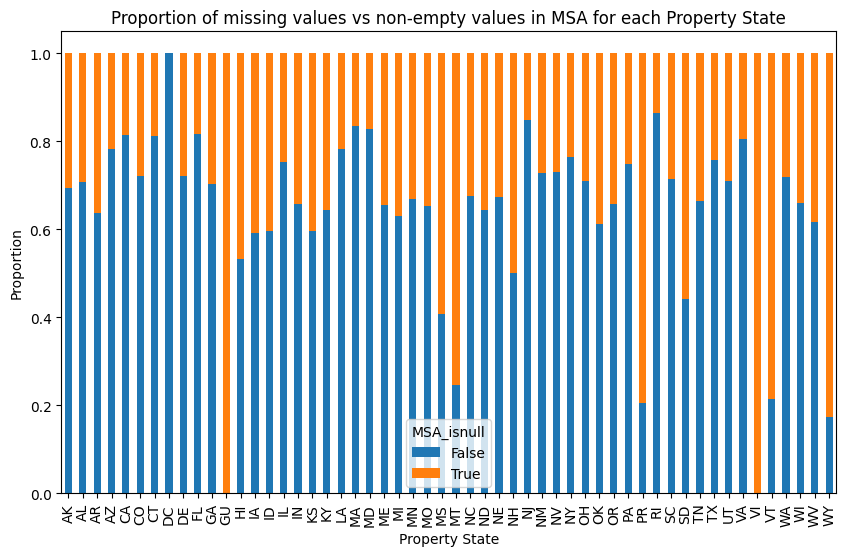

The number of unique Property State is 54


In [13]:
import matplotlib.pyplot as plt

# Calculate the proportion of missing values vs non-empty values for each "property state"
data_merged_simplified["MSA_isnull"] = data_merged_simplified[
    "Metropolitan Statistical Area (MSA) Or Metropolitan Division"
].isnull()
grouped = (
    data_merged_simplified.groupby("Property State")["MSA_isnull"]
    .value_counts(normalize=True)
    .rename("proportion")
    .reset_index()
)

# Pivot the data for the stacked bar chart
pivot_df = grouped.pivot(
    index="Property State", columns="MSA_isnull", values="proportion"
)

# Create a percent stacked bar chart
pivot_df.plot(kind="bar", stacked=True, figsize=(10, 6))
plt.title(
    "Proportion of missing values vs non-empty values in MSA for each Property State"
)
plt.ylabel("Proportion")
plt.show()

# Count the number of unique Property State
unique_property_state = data_merged_simplified["Property State"].nunique()
print(f"The number of unique Property State is {unique_property_state}")


The MSA or Metropolitan Division variable is not suitable for our analysis because to specifically determine a city with high mortgage delinquency rates, ideally, we would need the total number of mortgages for each city with their respective delinquency indicators, and then compare them with the average of the rest of the cities. In this case, as we can see in the graph, we do not have information for all cities because there are states for which we only have null values, and we need to have at least a representative sample of the city data. The major problem this causes us during testing and deployment is that we won't be able to make a good generalization or prediction of the data because we didn't initially provide the model with enough information about the representativeness of the different cities and delinquency rates.

### Exercise 9

For your analysis, include the following variables: 

```
Credit Score
First Time Homebuyer Flag
Number of Units
Mortgage Insurance Percentage (MI %)
Occupancy Status
Original Debt-to-Income (DTI) Ratio
Original UPB
Original Loan-to-Value (LTV)
Original Interest Rate
Channel
Prepayment Penalty Mortgage (PPM) Flag
Amortization Type (Formerly Product Type)
Property State
Property Type
Original Loan Term
Number of Borrowers
Interest Only (I/O) Indicator
```

Be sure to clean these variables. When doing so, please treat missing data as missing (e.g., `np.nan`, not as a distinct category).

In [14]:
subset_names = [
    "Credit Score",
    "First Time Homebuyer Flag",
    "Number of Units",
    "Mortgage Insurance Percentage (MI %)",
    "Occupancy Status",
    "Original Debt-to-Income (DTI) Ratio",
    "Original UPB",
    "Original Loan-to-Value (LTV)",
    "Original Interest Rate",
    "Channel",
    "Prepayment Penalty Mortgage (PPM) Flag",
    "Amortization Type (Formerly Product Type)",
    "Property State",
    "Property Type",
    "Original Loan Term",
    "Number of Borrowers",
    "Interest Only (I/O) Indicator",
    "Loan Sequence Number",
    "Delinquent",
]

# Count the number of element in subset_names
number_of_elements = len(subset_names)
print(f"The number of elements in subset_names is {number_of_elements}")

The number of elements in subset_names is 19


In [15]:
# Let's create a subset of the data with the columns in subset_names
data_subset = data_merged_simplified[subset_names]

# Verify the number of columns in the data_subset
number_of_columns = data_subset.shape[1]
print(f"The number of columns in the data_subset is {number_of_columns}")

The number of columns in the data_subset is 19


In [16]:
# Give me a summare of the values in each column of the data_subset
summary = data_subset.describe()
print(summary)

       Credit Score  Number of Units  Mortgage Insurance Percentage (MI %)  \
count  17471.000000     17471.000000                          17471.000000   
mean     750.469292         1.042699                              6.127010   
std      446.083481         1.299512                             15.552428   
min      300.000000         1.000000                              0.000000   
25%      693.000000         1.000000                              0.000000   
50%      739.000000         1.000000                              0.000000   
75%      772.000000         1.000000                              0.000000   
max     9999.000000        99.000000                            999.000000   

       Original Debt-to-Income (DTI) Ratio   Original UPB  \
count                         17471.000000   17471.000000   
mean                             55.050999  159484.688913   
std                             137.999359   79341.177321   
min                               1.000000   10000.00

In [17]:
# Let's check if the are missing values in any of the columns of the data_subset
missing_values = data_subset.isnull().sum()
print(missing_values)

Credit Score                                 0
First Time Homebuyer Flag                    0
Number of Units                              0
Mortgage Insurance Percentage (MI %)         0
Occupancy Status                             0
Original Debt-to-Income (DTI) Ratio          0
Original UPB                                 0
Original Loan-to-Value (LTV)                 0
Original Interest Rate                       0
Channel                                      0
Prepayment Penalty Mortgage (PPM) Flag       0
Amortization Type (Formerly Product Type)    0
Property State                               0
Property Type                                0
Original Loan Term                           0
Number of Borrowers                          0
Interest Only (I/O) Indicator                0
Loan Sequence Number                         0
Delinquent                                   0
dtype: int64


In [18]:
# Let's convert the missing values to np.nan
values_to_replace = {
    "Credit Score": 9999.000000,
    "Number of Units": 99.000000,
    "Mortgage Insurance Percentage (MI %)": 999.000000,
    "Original Debt-to-Income (DTI) Ratio": 999.000000,
    "Number of Borrowers": 99.000000,
}

# Replace the values with np.nan
for column, value in values_to_replace.items():
    data_subset[column] = data_subset[column].replace(value, np.nan)

In [19]:
# Give me a summare of the values in each column of the data_subset after cleaning
summary = data_subset.describe()
print(summary)

       Credit Score  Number of Units  Mortgage Insurance Percentage (MI %)  \
count  17431.000000     17468.000000                          17469.000000   
mean     729.246113         1.025876                              6.013338   
std       51.982726         0.201657                             11.358870   
min      300.000000         1.000000                              0.000000   
25%      693.000000         1.000000                              0.000000   
50%      739.000000         1.000000                              0.000000   
75%      772.000000         1.000000                              0.000000   
max      842.000000         4.000000                             42.000000   

       Original Debt-to-Income (DTI) Ratio   Original UPB  \
count                         17108.000000   17471.000000   
mean                             35.022153  159484.688913   
std                              11.808027   79341.177321   
min                               1.000000   10000.00

### Exercise 10

The next step in our analysis is to convert our categorical variables to one-hot-encodings and use `train_test_split` to split our data.

To ensure replicability, **before** you `train_test_split` your data, please sort your data by `Loan Sequence Number`. This will ensure when we split the data with a random seed below, everyone will get the same split and the autograder will function.

You may create your one-hot-encodings however you wish, but I'm a fan of the [patsy library's](https://patsy.readthedocs.io/en/latest/overview.html) `dmatrices` function.

Hint: You should end up with 8 categorical variables, including some binary flags and `Number_of_Borrowers`, `Number_of_Units` (which you could argue should be continuous, but I think are better treated as categorical).

Store the number of observations in your final dataset in `ex10_num_obs`.

In [20]:
# Let's sort of data by Loan Sequence Number
data_subset = data_subset.sort_values("Loan Sequence Number")

# Delete the column of Loan Sequence Number
data_subset = data_subset.drop(columns="Loan Sequence Number")

# Check on the dataset which variables are categorical and which are numerical and how many they are
categorical = data_subset.select_dtypes(include="object").columns

# Count the number of categorical variables
number_of_categorical = len(categorical)
numerical = data_subset.select_dtypes(include=["float64", "int64"]).columns

# Count the number of numerical variables
number_of_numerical = len(numerical)

print(f"The categorical variables are: \n {categorical}\n")
print(f"Categorical variables: {number_of_categorical}\n")
print(f"The numerical variables are: \n{numerical}\n")
print(f"Numerical variables: {number_of_numerical}\n")

# Count the number of observation in the data_subset
number_of_observation = data_subset.shape[0]
print(f"The number of observation in the data_subset is {number_of_observation}")

The categorical variables are: 
 Index(['First Time Homebuyer Flag', 'Occupancy Status', 'Channel',
       'Prepayment Penalty Mortgage (PPM) Flag',
       'Amortization Type (Formerly Product Type)', 'Property State',
       'Property Type', 'Interest Only (I/O) Indicator'],
      dtype='object')

Categorical variables: 8

The numerical variables are: 
Index(['Credit Score', 'Number of Units',
       'Mortgage Insurance Percentage (MI %)',
       'Original Debt-to-Income (DTI) Ratio', 'Original UPB',
       'Original Loan-to-Value (LTV)', 'Original Interest Rate',
       'Original Loan Term', 'Number of Borrowers', 'Delinquent'],
      dtype='object')

Numerical variables: 10

The number of observation in the data_subset is 17471


In [21]:
import patsy

# Give me the unique values for each of the categorical variables
unique_values = {}
for column in categorical:
    unique_values[column] = data_subset[column].unique()
# print(unique_values)

# Drop the values in column Property Type = 99 and First Time Homebuyer Flag = 9
data_subset = data_subset[
    (data_subset["Property Type"] != "99")
    & (data_subset["First Time Homebuyer Flag"] != "9")
]
# Drop de na values
data_subset = data_subset.dropna()

formula = 'Q("Delinquent")~-1 +Q("Credit Score") + C(Q("First Time Homebuyer Flag")) + C(Q("Number of Units")) + Q("Mortgage Insurance Percentage (MI %)") + C(Q("Occupancy Status")) + Q("Original Debt-to-Income (DTI) Ratio") + Q("Original UPB") + Q("Original Loan-to-Value (LTV)") + Q("Original Interest Rate") + C(Q("Channel")) + C(Q("Prepayment Penalty Mortgage (PPM) Flag")) + C(Q("Amortization Type (Formerly Product Type)")) + C(Q("Property State")) + C(Q("Property Type")) + Q("Original Loan Term") + C(Q("Number of Borrowers")) + C(Q("Interest Only (I/O) Indicator"))'

y, X = patsy.dmatrices(formula, data=data_subset, return_type="dataframe")


# Display shapes of X and Y
print("Shape of X:", X.shape)
print("Shape of y:", y.shape)

number_of_observation = X.shape[0]
print(f"The number of observation in at this point is {number_of_observation}")

results["ex10_num_obs"] = number_of_observation

Shape of X: (17052, 76)
Shape of y: (17052, 1)
The number of observation in at this point is 17052


### Exercise 11

Use `train_test_split` from `sklearn.model_selection` to split the data. 

Before you do, Use `0.2` as the `test_size` and use `random_state=42`.

In [22]:
# Train our data with test_size = 0.2 and random_state = 42
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

### Exercise 12

Now fit a `GradientBoostingClassifier` to the data (from `sklearn.ensemble`). Set `random_state=42`. using `roc_auc_score`, get your ROC AUC score against the test data. Store in `results` under the key `"ex12_roc_auc"`.

In [23]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_auc_score

# Initialize the GradientBoostingClassifier
clf = GradientBoostingClassifier(random_state=42)

# Fit the model to the training data
clf.fit(X_train, y_train.values.ravel())

# Predict the probabilities of the positive class for the test data
y_pred_proba = clf.predict_proba(X_test)[:, 1]

# Calculate the ROC AUC score
roc_auc = roc_auc_score(y_test, y_pred_proba)

# Store the result, round to 4 decimal places
results["ex12_roc_auc"] = round(roc_auc, 4)

print(f"The ROC AUC score is {roc_auc}")

The ROC AUC score is 0.708437747622821


### Exercise 13

Use the `predict` method to generate a confusion matrix. What problem do you see with the result?

In [24]:
from sklearn.metrics import confusion_matrix

# Assume that you have a model 'clf' and test data 'X_test' and 'y_test'
y_pred = clf.predict(X_test)

# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

print(cm)

[[3146    9]
 [ 252    4]]


>True Negatives(TN): The model accurately predicted 3,146 loans as not going to be delinquent, meaning it correctly identified those that would stay in good standing.False Positives(FP): The model incorrectly flagged 9 loans as potentially delinquent when, in reality, they remained non-delinquent. This means it mistakenly thought these loans would have payment issues, but they didn't. False Negatives (FN): The model missed identifying 252 loans that ended up being delinquent. It predicted these loans would be in good standing, but they weren't, indicating the model overlooked signs of potential delinquency. True Positives(TP): The model correctly identified 4 loans as becoming delinquent, accurately predicting these loans would have payment issues.

### Exercise 14

To address the problem from Exercise 13, use `.predict_proba()` to set your own threshold for classification. Your stakeholder is mostly concerned with False Omission (mortgages classified as safe that actually are not), so use a 8% probability threshold to get a good balance of a low False Omission rate with a reasonable amount of mortgages still being considered "viable."

What is the False Negative rate at an 8% classification threshold from the model above?

Store the result under the key `"ex14_false_omission_rate"`.

In [25]:
from sklearn.metrics import confusion_matrix

# Generate predicted probabilities
y_pred_proba = clf.predict_proba(X_test)[:, 1]

# Set a custom threshold for classification
threshold = 0.08
y_pred_custom = (y_pred_proba > threshold).astype(int)

# Generate the confusion matrix
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_custom).ravel()

# Calculate the False Omission Rate
false_negative_rate = fn / (fn + tn)

# Store the result
results["ex14_false_omission_rate"] = false_negative_rate

print(f"The False Negative Rate is {false_negative_rate}")

The False Negative Rate is 0.04900398406374502


### Exercise 15

Your stakeholder wants to by as many mortgages as it can while maintaining a delinquency rate of purchased mortgages below 5%. Based on your answer above, do you feel like your model can provide that level of performance?

>Given the outcome, with a False Omission Rate at 8% classification threshold of 0.049 (or 4.9%), the model meets the stakeholder's requirement of maintaining a delinquency rate of purchased mortgages below 5%. This suggests that by applying this model with the specified threshold, the stakeholder can confidently purchase mortgages while keeping the risk of delinquency within acceptable bounds, thus achieving the goal of maximizing acquisitions with a controlled level of risk.

## Now To The Future

The preceding analysis is precisely the type of analysis you would do if, in late 2006, you'd been asked to evaluate mortgage performance in the last two years for use going forward. So let's see how your model performs now!

In this [folder](https://github.com/nickeubank/MIDS_Data/tree/master/mortgages/2007) you will find data on mortgages originated in 2007 along with servicing data from 2007, 2008, and 2009.

### Exercise 16

Please load this data (again, from a URL to help the autograder) and clean it in the same manner as before. As a sanity check, how many observations do you have in the final dataset (after you've removed observations with missing values to allow you to generate predicted delinquency rates)? 

Store the final number of observations in `"ex16_num_obs"` and the share of those mortgages that are delinquent in `"ex16_share_delinquent"`


In [26]:
# Set the URL for the data
url_orig_2007 = "https://github.com/nickeubank/MIDS_Data/raw/master/mortgages/2007/sample_orig_2007.txt"
url_svcg_2007 = "https://github.com/nickeubank/MIDS_Data/raw/master/mortgages/2007/sample_svcg_2007orig_3years.txt"

head_labels_orig = [
    "Credit Score",
    "First Payment Date",
    "First Time Homebuyer Flag",
    "Maturity Date",
    "Metropolitan Statistical Area (MSA) Or Metropolitan Division",
    "Mortgage Insurance Percentage (MI %)",
    "Number of Units",
    "Occupancy Status",
    "Original Combined Loan-to-Value (CLTV)",
    "Original Debt-to-Income (DTI) Ratio",
    "Original UPB",
    "Original Loan-to-Value (LTV)",
    "Original Interest Rate",
    "Channel",
    "Prepayment Penalty Mortgage (PPM) Flag",
    "Amortization Type (Formerly Product Type)",
    "Property State",
    "Property Type",
    "Postal Code",
    "Loan Sequence Number",
    "Loan Purpose",
    "Original Loan Term",
    "Number of Borrowers",
    "Seller Name",
    "Servicer Name",
    "Super Conforming Flag",
    "Pre-HARP Loan Sequence Number",
    "Program Indicator",
    "HARP Indicator",
    "Property Valuation Method",
    "Interest Only (I/O) Indicator",
    "Mortgage Insurance Cancellation Indicator",
]

head_labels_svcg = [
    "Loan Sequence Number",
    "Monthly Reporting Period",
    "Current Actual UPB",
    "Current Loan Delinquency Status",
    "Loan Age",
    "Remaining Months to Legal Maturity",
    "Defect Settlement Date",
    "Modification Flag",
    "Zero Balance Code",
    "Zero Balance Effective Date",
    "Current Interest Rate",
    "Current Deferred UPB",
    "Due Date of Last Paid Installment (DDLPI)",
    "MI Recoveries",
    "Net Sales Proceeds",
    "Non MI Recoveries",
    "Expenses",
    "Legal Costs",
    "Maintenance and Preservation Costs",
    "Taxes and Insurance",
    "Miscellaneous Expenses",
    "Actual Loss Calculation",
    "Modification Cost",
    "Step Modification Flag",
    "Deferred Payment Plan",
    "Estimated Loan-to-Value (ELTV)",
    "Zero Balance Removal UPB",
    "Delinquent Accrued Interest",
    "Delinquency Due to Disaster",
    "Borrower Assistance Status Code",
    "Current Month Modification Cost",
    "Interest Bearing UPB",
]

data_orig_2007 = pd.read_csv(
    url_orig_2007, sep="|", header=None, names=head_labels_orig
)
data_svcg_2007 = pd.read_csv(
    url_svcg_2007, sep="|", header=None, names=head_labels_svcg
)

data_merged_2007 = pd.merge(
    data_orig_2007,
    data_svcg_2007,
    on="Loan Sequence Number",
    how="inner",
    validate="one_to_many",
)


# Lets subset our data by Loan Purpose = P
data_merged_purchase_2007 = data_merged_2007[data_merged_2007["Loan Purpose"] == "P"]

# Lets create a new column with the first 4 characters of the Loan Sequence Number
data_merged_purchase_2007["LoanSequenceNumber_Date"] = data_merged_purchase_2007[
    "Loan Sequence Number"
].str[1:5]

# Lets extract the last 4 numbers from First Payment Date
data_merged_purchase_2007["FirstPaymentDate_Date"] = (
    data_merged_purchase_2007["First Payment Date"].astype(str).str[-4:]
)


# Modify the FirstPaymentDate_Date to put Q1 when found 01,02,03 in the last 2 digits
def quarter_mapper(month):
    if month in ["01", "02", "03"]:
        return "Q1"
    elif month in ["04", "05", "06"]:
        return "Q2"
    elif month in ["07", "08", "09"]:
        return "Q3"
    else:
        return "Q4"


data_merged_purchase_2007["FirstPaymentDate_Date_Quarters"] = data_merged_purchase_2007[
    "FirstPaymentDate_Date"
].apply(lambda x: x[:2] + quarter_mapper(x[-2:]))


# Create a new column adding 1 to the last digit of the LoanSequenceNumber_Date
def add_one_to_last_digit(x):
    if x[-1].isdigit():
        if x[-1] == "4":
            return x[0] + str(int(x[1]) + 1) + x[2:-1] + "1"
        else:
            return x[:-1] + str(int(x[-1]) + 1)
    else:
        return x


data_merged_purchase_2007["LoanSequenceNumber_Date_Plus1"] = data_merged_purchase_2007[
    "LoanSequenceNumber_Date"
].apply(add_one_to_last_digit)

# Keep only the columns where FirstPaymentDate_Date_Quarters is equal to LoanSequenceNumber_Date_Plus1 or LoanSequenceNumber_Date
data_merged_purchase_2007 = data_merged_purchase_2007[
    (
        data_merged_purchase_2007["FirstPaymentDate_Date_Quarters"]
        == data_merged_purchase_2007["LoanSequenceNumber_Date_Plus1"]
    )
    | (
        data_merged_purchase_2007["FirstPaymentDate_Date_Quarters"]
        == data_merged_purchase_2007["LoanSequenceNumber_Date"]
    )
]

# Lets see how many unique Loan Sequence Numbers we have
unique_loan_sequence_numbers = data_merged_purchase_2007[
    "Loan Sequence Number"
].nunique()

# Add 24 months to the column of First Payment Date
data_merged_purchase_2007["First Payment Date + 24 months"] = pd.to_datetime(
    data_merged_purchase_2007["First Payment Date"], format="%Y%m"
) + DateOffset(months=23)

# print(data_merged_purchase["First Payment Date + 24 months"])

# Convert the column of Monthly Reporting Period to datetime
data_merged_purchase_2007["Monthly Reporting Period_Comparison"] = pd.to_datetime(
    data_merged_purchase_2007["Monthly Reporting Period"], format="%Y%m"
)

# Filter the column of Monthly Reporting Period that are lower than the First Payment Date + 24 months
# and greater than or equal to First Payment Date
data_merged_purchase_2007 = data_merged_purchase_2007[
    (
        data_merged_purchase_2007["Monthly Reporting Period_Comparison"]
        >= pd.to_datetime(
            data_merged_purchase_2007["First Payment Date"], format="%Y%m"
        )
    )
    & (
        data_merged_purchase_2007["Monthly Reporting Period_Comparison"]
        <= data_merged_purchase_2007["First Payment Date + 24 months"]
    )
]
# Remaining observations
remaining_observations = data_merged_purchase_2007.shape[0]


# Transform the column of Current Loan Delinquency Status to numeric
data_merged_purchase_2007["Current Loan Delinquency Status"] = pd.to_numeric(
    data_merged_purchase_2007["Current Loan Delinquency Status"], errors="coerce"
)

# Create an indicator of 1 if the mortgage is has been delingquent based on the column of Current Loan Delinquency Status
data_merged_purchase_2007["Delinquent"] = data_merged_purchase_2007[
    "Current Loan Delinquency Status"
].apply(lambda x: 0 if x == 0 else 1)

head_labels_svcg_modified = [
    "Monthly Reporting Period",
    "Current Actual UPB",
    "Current Loan Delinquency Status",
    "Loan Age",
    "Remaining Months to Legal Maturity",
    "Defect Settlement Date",
    "Modification Flag",
    "Zero Balance Code",
    "Zero Balance Effective Date",
    "Current Interest Rate",
    "Current Deferred UPB",
    "Due Date of Last Paid Installment (DDLPI)",
    "MI Recoveries",
    "Net Sales Proceeds",
    "Non MI Recoveries",
    "Expenses",
    "Legal Costs",
    "Maintenance and Preservation Costs",
    "Taxes and Insurance",
    "Miscellaneous Expenses",
    "Actual Loss Calculation",
    "Modification Cost",
    "Step Modification Flag",
    "Deferred Payment Plan",
    "Estimated Loan-to-Value (ELTV)",
    "Zero Balance Removal UPB",
    "Delinquent Accrued Interest",
    "Delinquency Due to Disaster",
    "Borrower Assistance Status Code",
    "Current Month Modification Cost",
    "Interest Bearing UPB",
]


# Delete all the columns with headers equal to head_labels_svcg
data_merged_simplified_2007 = data_merged_purchase_2007.drop(
    columns=head_labels_svcg_modified
)

# Delete all the duplicates in the column of Loan Sequence Number but if Delinquent is 1 keep that record
data_merged_simplified_2007 = data_merged_simplified_2007.sort_values(
    "Delinquent", ascending=False
).drop_duplicates(subset=["Loan Sequence Number"])

# Count the number of Loan Sequence Numbers
count_loan_sequence_numbers = data_merged_simplified_2007[
    "Loan Sequence Number"
].count()


# Count the number of Loan Sequence Numbers that at least have one delinquent in the column Delinquent
count_loan_sequence_numbers_delinquent = data_merged_simplified_2007[
    data_merged_simplified_2007["Delinquent"] == 1
]["Loan Sequence Number"].count()

# Calculate the percentage of Loan Sequence Numbers that at least have one delinquent in the column Delinquent
percentage_loan_sequence_numbers_delinquent = (
    count_loan_sequence_numbers_delinquent / count_loan_sequence_numbers
) * 100

subset_names = [
    "Credit Score",
    "First Time Homebuyer Flag",
    "Number of Units",
    "Mortgage Insurance Percentage (MI %)",
    "Occupancy Status",
    "Original Debt-to-Income (DTI) Ratio",
    "Original UPB",
    "Original Loan-to-Value (LTV)",
    "Original Interest Rate",
    "Channel",
    "Prepayment Penalty Mortgage (PPM) Flag",
    "Amortization Type (Formerly Product Type)",
    "Property State",
    "Property Type",
    "Original Loan Term",
    "Number of Borrowers",
    "Interest Only (I/O) Indicator",
    "Loan Sequence Number",
    "Delinquent",
]

# Count the number of element in subset_names
number_of_elements = len(subset_names)

# Create a new dataframe with the subset_names

# Let's create a subset of the data with the columns in subset_names
data_subset_2007 = data_merged_simplified_2007[subset_names]

# Verify the number of columns in the data_subset
number_of_columns = data_subset_2007.shape[1]

# Give me a summare of the values in each column of the data_subset
summary = data_subset_2007.describe()
# print(summary)
# Let's check if the are missing values in any of the columns of the data_subset
missing_values = data_subset_2007.isnull().sum()
# print(missing_values)
# Let's convert the missing values to np.nan
values_to_replace = {
    "Credit Score": [9999, 9999.0],
    "Number of Units": [99, 99.0],
    "Mortgage Insurance Percentage (MI %)": [999, 999.0],
    "Original Debt-to-Income (DTI) Ratio": [999, 999.0],
    "Number of Borrowers": [99, 99.0],
    "First Time Homebuyer Flag": ["9"],
}

# Print the type of First Time Homebuyer Flag
# print(data_subset_2007["First Time Homebuyer Flag"].dtype)


# Replace the values with np.nan
for column, values in values_to_replace.items():
    for value in values:
        data_subset_2007[column] = data_subset_2007[column].replace(value, np.nan)

# Delete the columns with np.nan values
data_subset_2007 = data_subset_2007.dropna()

# Let's sort of data by Loan Sequence Number
data_subset_2007 = data_subset_2007.sort_values("Loan Sequence Number")

# Delete the column of Loan Sequence Number
data_subset_2007 = data_subset_2007.drop(columns="Loan Sequence Number")


y_2007, X_2007 = patsy.dmatrices(
    formula, data=data_subset_2007, return_type="dataframe"
)

In [27]:
# Count the number of Delinquent that at least have one delinquent in the column Delinquent
count_loan_sequence_numbers_delinquent_2007 = (
    data_subset_2007["Delinquent"] == 1
).sum()

# Count the number of rows in Delinquent
number_of_observation_2007 = data_subset_2007.shape[0]

# Calculate the percentage of Loan Sequence Numbers that at least have one delinquent in the column Delinquent
percentage_loan_sequence_numbers_delinquent_2007 = (
    count_loan_sequence_numbers_delinquent_2007 / number_of_observation_2007
) * 100
print(
    f"The percentage of share Delinquent is {percentage_loan_sequence_numbers_delinquent_2007}%"
)

results["ex16_share_delinquent"] = (
    percentage_loan_sequence_numbers_delinquent_2007 / 100
)

The percentage of share Delinquent is 10.96395412342982%


In [28]:
number_of_observation_2007 = data_subset_2007.shape[0]
print(f"The number of observation in the data_subset is {number_of_observation_2007}")

results["ex16_num_obs"] = number_of_observation_2007

results

The number of observation in the data_subset is 21972


{'ex2_merge_type': '1:m',
 'ex4_num_mortgages': 17504,
 'ex5_num_obs': 379461,
 'ex7_num_mortgages': 17471,
 'ex7_share_delinquent': 0.07108923358708717,
 'ex10_num_obs': 17052,
 'ex12_roc_auc': 0.7084,
 'ex14_false_omission_rate': 0.04900398406374502,
 'ex16_share_delinquent': 0.1096395412342982,
 'ex16_num_obs': 21972}

### Exercise 17




Had your stakeholder purchased mortgages using your model, what would the resulting False Omission Rate have been? (e.g., compare the predicted values for mortgages using the model trained above with realized outcomes). Store your result under the key `"ex17_false_omission_rate"`


In [29]:
X_2007.rename(
    columns={'C(Q("Number of Units"))[T.2]': 'C(Q("Number of Units"))[T.2.0]'},
    inplace=True,
)

X_2007.rename(
    columns={'C(Q("Number of Units"))[T.3]': 'C(Q("Number of Units"))[T.3.0]'},
    inplace=True,
)

X_2007.rename(
    columns={'C(Q("Number of Units"))[T.4]': 'C(Q("Number of Units"))[T.4.0]'},
    inplace=True,
)

In [30]:
y_hat_prob_2007 = clf.predict_proba(X_2007)[:, 1]
y_hat_08_2007 = (y_hat_prob_2007 > 0.08).astype(int)

false_omission_rate_2007 = ((y_hat_08_2007 == 0) & (y_2007.squeeze() == 1)).sum() / (
    (y_hat_08_2007 == 0).sum()
)

# Round to 4 decimal places
false_omission_rate_2007 = round(false_omission_rate_2007, 4)


results["ex17_false_omission_rate"] = false_omission_rate_2007

print(f"The False Omission Rate is {false_omission_rate_2007}")

The False Omission Rate is 0.0553


In [31]:
results

{'ex2_merge_type': '1:m',
 'ex4_num_mortgages': 17504,
 'ex5_num_obs': 379461,
 'ex7_num_mortgages': 17471,
 'ex7_share_delinquent': 0.07108923358708717,
 'ex10_num_obs': 17052,
 'ex12_roc_auc': 0.7084,
 'ex14_false_omission_rate': 0.04900398406374502,
 'ex16_share_delinquent': 0.1096395412342982,
 'ex16_num_obs': 21972,
 'ex17_false_omission_rate': 0.0553}

### Exercise 18

How did the retrospective performance of your model compare to its actual performance moving forward? Why? Did you stay below the 5% target for mortgages that were predicted to be safe but in the end were not set by the stakeholder?

>The retrospective performance, based on historical data in 2007 in this case, gives us an insight into how well the model was able to predict loan delinquency. A FOR of 0.0553 means that, retrospectively, 5.53% of loans that were predicted to be non-delinquent (safe) ended up being delinquent. This performance metric is crucial for understanding how well the model identifies loans at risk of delinquency. The FOR of 0.0553 indicates that the model did not stay below the 5% target set by the stakeholder for mortgages predicted to be safe but ended up being delinquent. This suggests that the model was slightly more optimistic in predicting loan safety, leading to a higher rate of missed delinquent loans than the stakeholder's target. 

In [32]:
assert set(results.keys()) == {
    "ex2_merge_type",
    "ex4_num_mortgages",
    "ex5_num_obs",
    "ex7_num_mortgages",
    "ex7_share_delinquent",
    "ex10_num_obs",
    "ex12_roc_auc",
    "ex14_false_omission_rate",
    "ex16_num_obs",
    "ex16_share_delinquent",
    "ex17_false_omission_rate",
}

results

{'ex2_merge_type': '1:m',
 'ex4_num_mortgages': 17504,
 'ex5_num_obs': 379461,
 'ex7_num_mortgages': 17471,
 'ex7_share_delinquent': 0.07108923358708717,
 'ex10_num_obs': 17052,
 'ex12_roc_auc': 0.7084,
 'ex14_false_omission_rate': 0.04900398406374502,
 'ex16_share_delinquent': 0.1096395412342982,
 'ex16_num_obs': 21972,
 'ex17_false_omission_rate': 0.0553}